# __1. Nh·∫≠p th∆∞ vi·ªán__

In [31]:
# # Connect to gg drive
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
# !pip install keras-tuner
# !pip install scikeras
# !pip install underthesea
# !pip install pyvi
# !pip install import-ipynb

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
import underthesea

import string
import re
import nltk
from underthesea import word_tokenize, pos_tag
from pyvi import ViTokenizer, ViPosTagger
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score



[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nguyen_Thanh_Vinh\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
import import_ipynb
import MLTunning as MLT

# __2. Vectorize - word indexing__

In [35]:
def process_tweet(tweet):
    # T√°ch t·ª´ v√† g√°n nh√£n t·ª´ lo·∫°i
    tweet_tokens = pos_tag(word_tokenize(tweet, format='text'))

    # X·ª≠ l√Ω t·ª´ng t·ª´
    tweets_clean = []
    for word, pos in tweet_tokens:
        if word not in string.punctuation:
            # G√°n nh√£n t·ª´ lo·∫°i ph√π h·ª£p
            lemma_word = lemmatizer.lemmatize(word, pos_tag_convert_vietnamese(pos)) # Chuy·ªÉn v·ªÅ d·∫°ng g·ªëc c·ªßa t·ª´, n·∫øu d√πng cho Ti·∫øng Vi·ªát th√¨ kh√¥ng c·∫ßn. Ch·ªâ c·∫ßn POS tag v√† ch·ªçn t·ª´ quan tr·ªçng.
            tweets_clean.append(lemma_word)

    return tweets_clean
def pos_tag_convert_vietnamese(tag):
    """
    Chuy·ªÉn ƒë·ªïi nh√£n t·ª´ lo·∫°i c·ªßa Ti·∫øng Vi·ªát sang c√°c nh√£n t∆∞∆°ng ·ª©ng trong WordNet
    """
    if tag.startswith('A'):  # T√≠nh t·ª´
        return wordnet.ADJ
    elif tag.startswith('V'):  # ƒê·ªông t·ª´
        return wordnet.VERB
    elif tag.startswith('N'):  # Danh t·ª´
        return wordnet.NOUN
    elif tag.startswith('R'):  # Tr·∫°ng t·ª´
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [36]:
def build_vocabulary(corpus):
    vocab = {'': 0, '[UNK]': 1}

    for tweet in corpus:
        for word in tweet:
            if word not in vocab:
                vocab[word] = len(vocab)

    return vocab

In [37]:
def max_length(training_x, validation_x):

    max_len = -1
    for tweet in training_x:
        if max_len < len(tweet): max_len = len(tweet)

    for tweet in validation_x:
        if max_len < len(tweet): max_len = len(tweet)

    return max_len

In [38]:
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    unk_ID = vocab_dict[unk_token]
    tensor_l = []

    for word in tweet:

        word_ID = vocab_dict[word] if word in vocab_dict else unk_ID
        tensor_l.append(word_ID)

    padded_tensor = tensor_l + [0] * (max_len - len(tensor_l))

    return padded_tensor

# __4. Hyperparameter tunning - DL__

In [39]:
num_words = 0
max_len = 0

In [72]:
import keras_tuner as kt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    embedding_dim = 16
    model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len))

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )
    return model

# __5. Ph√¢n t√≠ch ƒë√°nh gi√° c√¢u d√†i - data full__

### ___5.1. ƒê·ªçc v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu___

In [41]:
file_path = r'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\preprocessed_data.xlsx'
df = pd.read_excel(file_path)
df.head()

content_comments  \
0  thay ƒë·ªïi coment tƒÉng  size h√£y l√†m nh∆∞ b·∫°n mu·ªë...   
1  qu·∫ßn d√†y m·ªói l·∫ßn size nh·ªè nh·∫Øn tin c·ª≠a h√†ng ƒë·ªï...   
2  ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng g√≥i m√†u ƒë√∫ng m·∫´u ƒë√∫ng sau s·∫Ω...   
3  ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng g√≥i sizes·∫Ω kh·∫£ nƒÉng quay l·∫°i...   
4  h√¨nh ·∫£nh nh·∫≠n xu v√† quan ƒë∆°n gi·∫£n th√¥i mua nhi...   

                                         comment_eng  sentiment  \
0  Change the cmt to increase 1 size. Please do a...          0   
1  thick pants\nEvery time the size is small, mes...          0   
2  Received the goods...shop packaged quickly...r...          1   
3  Received the goods...shop packaged quickly...r...          1   
4  The picture of receipt of coin and quan is sim...          0   

                                       word_tokenize  
0  thay_ƒë·ªïi coment tƒÉng size h√£y l√†m nh∆∞ b·∫°n mu·ªën...  
1  qu·∫ßn d√†y m·ªói l·∫ßn size nh·ªè_nh·∫Øn tin c·ª≠a_h√†ng ƒë·ªï...  
2  ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng_g√≥i m√†u ƒë√∫ng m·∫´u ƒë√∫ng sau s·∫Ω...  
3  ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng_g√≥i sizes·∫Ω kh·∫£_nƒÉng quay l·∫°i...  
4  h√¨nh_·∫£nh nh·∫≠n xu v√† quan ƒë∆°n_gi·∫£n th√¥i mua nhi...

### ___5.2. text vectorizer - word index - Full___

In [42]:
all_tweets = df['word_tokenize']
all_tweets = [str(t) if not isinstance(t, str) else t for t in all_tweets]
all_tweets

['thay_ƒë·ªïi coment tƒÉng size h√£y l√†m nh∆∞ b·∫°n mu·ªën b·∫°n c√≥ mu·ªën ƒëi·ªán_tho·∫°i c·ªßa m√¨nh tƒÉng l√™n k√≠ch_c·ª° kh√¥ng ƒë√†n h·ªìi d√†y tui ziper v·ª´a size xin_l·ªói',
 'qu·∫ßn d√†y m·ªói l·∫ßn size nh·ªè_nh·∫Øn tin c·ª≠a_h√†ng ƒë·ªïi size l·ªõn h∆°n nh∆∞ng c·ª≠a_h√†ng kh√¥ng tr·∫£ ƒëang l√†m_ƒÉn r·∫•t t·ªá',
 'ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng_g√≥i m√†u ƒë√∫ng m·∫´u ƒë√∫ng sau s·∫Ω kh·∫£_nƒÉng quay l·∫°i ·ªßng_h·ªô c√°c b·∫°n ·ªßng_h·ªô',
 'ƒë√£ nh·∫≠n ƒë∆∞·ª£c ƒë√≥ng_g√≥i sizes·∫Ω kh·∫£_nƒÉng quay l·∫°i ·ªßng_h·ªô c·ª≠a_h√†ng l·∫ßn sauh√£y gh√© ·ªßng_h·ªô c·ª≠a_h√†ng nh√©',
 'h√¨nh_·∫£nh nh·∫≠n xu v√† quan ƒë∆°n_gi·∫£n th√¥i mua nhi·ªÅu l·∫ßn r·ªìi nh∆∞ng l·∫ßn n√†y v·∫£i c√≥_v·∫ª m·ªèng h∆°n l·∫ßn tr∆∞·ªõc th√¨ mua ·ªü ƒë√¢u nh·ªâ',
 'n·∫øu b·∫°n ƒëang b·ªã qu·∫ßng th√¢m v√† b·ªçng m·∫Øt nh∆∞ t√¥i th√¨ h√£y ƒëi ƒëi·ªÅu_tr·ªã ngay ƒë√¢y t√¥i t·ª´ng b·ªã stres v√¨ ƒë√¥i m·∫Øt th√¢m_qu·∫ßng v√† b·ªçng_m·∫Øt kh·ªßng_khi·∫øp t√¥i sinh ra ƒë√£ m·∫Øc b·ªánh n√†y ng·ªß s·ªõm c≈©ng

In [43]:
all_tweets_processed = [process_tweet(tweet) for tweet in all_tweets]

In [44]:
# prompt: T·∫°o m·∫£ng x l∆∞u tr·ªØ c√°c gi√° tr·ªã trong c·ªôt word_tokenize v√† m·∫£ng y l∆∞u tr·ªØ gi√° tr·ªã trong c·ªôt sentiment

x = all_tweets_processed
y = df['sentiment'].values

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 832 sentences for training.
There are 832 labels for training.

There are 208 sentences for validation.
There are 208 labels for validation.


In [45]:
vocab = build_vocabulary(train_x)
num_words = len(vocab)
print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 1831 words

{'': 0, '[UNK]': 1, 'giao': 2, 'h√†ng': 3, 'ƒë√∫ng': 4, 't√∫i': 5, 'c√≥': 6, 'kh√≥a': 7, 'k√©o': 8, 'ti·ªán_l·ª£i': 9, 'ƒë·ªÉ': 10, 'ƒë·ª±ng': 11, 'ƒëi·ªán_tho·∫°i': 12, 'v·ª´a': 13, 'v·∫∑n': 14, 'v√†': 15, 'ch·∫•t_l∆∞·ª£ng': 16, 'chu·∫©n_b·ªã': 17, 'm·∫•t': 18, 'nhi·ªÅu': 19, 'th·ªùi_gian': 20, 'üò° __h·ªßy': 21, 'h√†ng_kh√¥ng': 22, 'nh·∫≠n': 23, 'th√¨': 24, 'l√†m_sao': 25, 'kinh_doanh': 26, 'ƒë∆∞·ª£c': 27, 'üñï': 28, 'kh√¥ng': 29, 'gi·ªëng': 30, 'm·∫´u': 31, 'ƒë·∫πp': 32, 'm√¥_t·∫£': 33, 'l·∫ßn': 34, 'sau': 35, 's·∫Ω': 36, 'mua': 37, 'ti·∫øp': 38, 'gi√°': 39, 'r·∫ª': 40, 'n√™n': 41, '√°o': 42, '·∫•n_t∆∞·ª£ng': 43, 'ch·∫•t': 44, 'v·∫£i': 45, 'm·ªèng_m√°t': 46, 'm√πa': 47, 'h√®': 48, 'nh∆∞ng': 49, 'qu·∫ßn': 50, 'm·ªèng': 51, 'qu√°': 52, 'l·ªô': 53, 'c·∫£': 54, 'b√™n': 55, 'trong': 56, 'ƒë∆∞·ªùng': 57, 'may_c·∫©u_th·∫£': 58, 'gi·∫∑t': 59, 'c·∫©n_th·∫≠n': 60, 'c√≥_th·ªÉ': 61, 'd·ªÖ_d√†ng': 62, 'khi·∫øn': 63, 's·ª£i': 64, 'ch·ªâ': 65, 'b·ªã': 66, 'bung': 

In [46]:
max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 150 tokens.


In [47]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

### ___5.3. M√¥ h√¨nh h·ªçc m√°y - Logistic regression___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Best score (Logistic regression): 0.632191039607532
Best Logistic regression Accuracy: 0.6009615384615384
Best Logistic regression Precision: 0.7477477477477478
Best Logistic regression Recall: 0.6014492753623188
Best Logistic regression AUC: 0.5903687192346987

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        97
           1       0.60      0.75      0.67       111

    accuracy                           0.60       208
   macro avg       0.60      0.59      0.58       208
weighted avg       0.60      0.60      0.59       208

ROC_AUC_SCORE is  0.5903687192346987


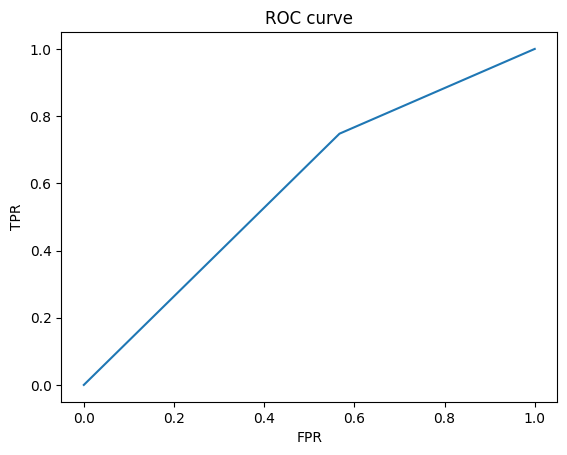

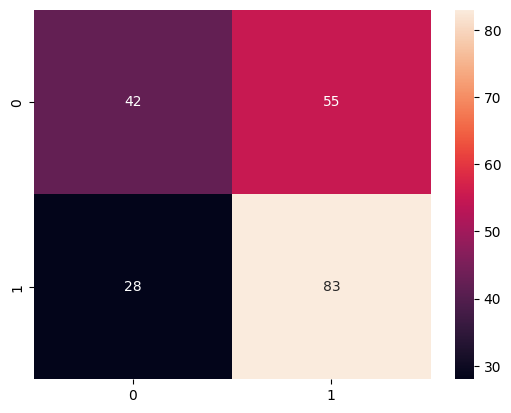

In [48]:
logreg_results = MLT.tune_logistic_regression(train_x_padded, train_y, val_x_padded, val_y)

In [49]:
best_logreg_model_split = logreg_results[0]

### ___5.4. M√¥ h√¨nh h·ªçc m√°y - Random forest___

In [50]:
rf_results = MLT.tune_random_forest(train_x_padded, train_y, val_x_padded, val_y)

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 37, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 73}
Best score (RandomForestClassifier): 0.6899213620950869
Best Random Forest Accuracy: 0.7259615384615384
Best Random Forest Precision: 0.8738738738738738
Best Random Forest Recall: 0.6928571428571428
Best Random Forest AUC: 0.7152874524008545
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.79      0.56      0.65        97
           1       0.69      0.87      0.77       111

    accuracy                           0.73       208
   macro avg       0.74      0.72      0.71       208
weighted avg       0.74      0.73      0.72       208

ROC_AUC_SCORE is  0.7152874524008545


In [51]:
best_rf_model_split = rf_results[0]

### ___5.5. M√¥ h√¨nh h·ªçc m√°y - Navie Bayes___

Best hyperparameters (MultinomialNB): {'alpha': 9.756545571902027}
Best score (MultinomialNB): 0.556640934997475
Best Navie Bayes Accuracy: 0.5673076923076923
Best Naive Bayes Precision: 0.38738738738738737
Best Navie Bayes Recall: 0.6615384615384615
Best Naive Bayes AUC: 0.5802916318380237
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        97
           1       0.66      0.39      0.49       111

    accuracy                           0.57       208
   macro avg       0.59      0.58      0.56       208
weighted avg       0.60      0.57      0.55       208

ROC_AUC_SCORE is  0.5802916318380237


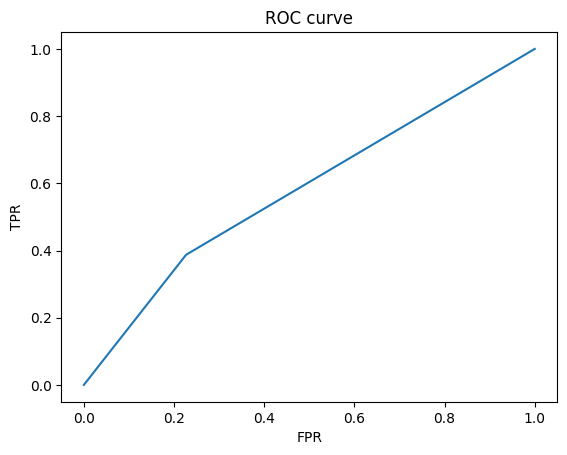

In [52]:
nb_results = MLT.tune_multinomial_nb(train_x_padded, train_y, val_x_padded, val_y)

In [53]:
best_nb_results_split = nb_results[0]

### ___5.6. M√¥ h√¨nh h·ªçc s√¢u - LSTM___

In [54]:
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

In [76]:
base_dir = r'sentiment_NK3'
project_name = 'intro_to_kt3'
directory = os.path.join(base_dir, project_name)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory=base_dir,
    project_name=project_name
)

# Ti·∫øn h√†nh t√¨m ki·∫øm si√™u tham s·ªë
tuner.search(train_x_prepared, train_y_prepared, epochs=10, validation_data=(val_x_prepared, val_y_prepared))

Trial 5 Complete [00h 01m 16s]
val_accuracy: 0.5336538553237915

Best val_accuracy So Far: 0.9471153616905212
Total elapsed time: 00h 06m 07s


In [77]:
# L·∫•y c√°c si√™u tham s·ªë t·ªët nh·∫•t
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
LSTM units: 64
Number of LSTM layers: 1
Learning rate: 0.0022261711101035104


# __6. Ph√¢n t√≠ch ƒë√°nh gi√° c√¢u ng·∫Øn - data split__

### ___6.1. ƒê·ªçc v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu___

In [56]:
file_path1 = r'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\preprocessed_data1.xlsx'
df1 = pd.read_excel(file_path1)
print(df1.head())

   Unnamed: 0                                            comment  \
0         3.0                                           thun d√†y   
1         4.0                                    t√∫i c√≥ kh√≥a k√©o   
2         NaN  m·ªói l·∫ßn size nh·ªè nh·∫Øn c·ª≠a h√†ng ƒë·ªïi size to h∆°n...   
3         8.0                                           qu·∫ßn d√†y   
4         9.0                                  ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng   

   sentiment_manual                                      word_tokenize  
0                 1                                           thun d√†y  
1                 1                                    t√∫i c√≥ kh√≥a k√©o  
2                 0  m·ªói l·∫ßn size nh·ªè_nh·∫Øn c·ª≠a_h√†ng ƒë·ªïi size to h∆°n...  
3                 1                                           qu·∫ßn d√†y  
4                 1                                  ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng  


### ___6.2. text vectorizer - word index - split___

In [57]:
all_tweets1 = df1['word_tokenize']
all_tweets1 = [str(t) if not isinstance(t, str) else t for t in all_tweets1]

In [58]:
all_tweets_processed1 = [process_tweet(tweet) for tweet in all_tweets1]

In [59]:
# prompt: T·∫°o m·∫£ng x l∆∞u tr·ªØ c√°c gi√° tr·ªã trong c·ªôt word_tokenize v√† m·∫£ng y l∆∞u tr·ªØ gi√° tr·ªã trong c·ªôt sentiment

x1 = all_tweets_processed1
y1 = df1['sentiment_manual'].values


from sklearn.model_selection import train_test_split
train_x1, val_x1, train_y1, val_y1 = train_test_split(x1, y1, test_size = 0.2, random_state = 42)

print(f"There are {len(train_x1)} sentences for training.")
print(f"There are {len(train_y1)} labels for training.\n")
print(f"There are {len(val_x1)} sentences for validation.")
print(f"There are {len(val_y1)} labels for validation.")


There are 6788 sentences for training.
There are 6788 labels for training.

There are 1697 sentences for validation.
There are 1697 labels for validation.


In [60]:
vocab1 = build_vocabulary(train_x1)
num_words1 = len(vocab1)
print(f"Vocabulary contains {num_words1} words\n")
print(vocab1)

Vocabulary contains 1977 words

{'': 0, '[UNK]': 1, 't√¥i': 2, 'ph·∫£i': 3, 'mua': 4, 'm·ªôt': 5, 'chi·∫øc': 6, '√°o': 7, 'kh√°c': 8, 'ƒë·ªÉ': 9, 'm·∫∑c': 10, 't√∫i': 11, 'kh√≥a': 12, 'k√©o': 13, 'ti·ªán_l·ª£i': 14, 'ƒë·ª±ng': 15, 'ƒëi·ªán_tho·∫°i': 16, 'm√¨nh': 17, 'nghƒ©': 18, 'th√™u': 19, 'th√¨': 20, 'ƒë·∫πp': 21, 'h∆°n': 22, 'g√≥i': 23, 'h√†ng': 24, 'c·∫©n_th·∫≠n': 25, 'sale': 26, 'gi√°': 27, 't·ªët': 28, 'c·∫£m_gi√°c': 29, 'nh∆∞': 30, 'ƒë·ªì': 31, 'c≈©': 32, 'v·∫≠y': 33, 'ü§î __sao': 34, 'v√¨': 35, 's·ª±': 36, 'b·∫•t_c·∫©n': 37, 'l·∫°i': 38, 'r·∫ª': 39, 'b·∫•t_ng·ªù': 40, 'l√£ng_ph√≠': 41, 'ti·ªÅn': 42, 'nh∆∞ng_m√†': 43, 'n√≥': 44, 'ch·ªâ': 45, 'l√†': 46, 's·∫£n_ph·∫©m': 47, 'may_ƒëo': 48, 'th√¥i': 49, 'c·ª≠a_h√†ng': 50, 't∆∞_v·∫•n': 51, 'ch·ªçn': 52, 'size': 53, 'v·ª´a': 54, 'v·∫∑n': 55, '√°p_d·ª•ng': 56, 'm√£': 57, 'ƒë·ª´ng': 58, 'm√†': 59, 'm·∫•t': 60, 'ch·∫•t_l∆∞·ª£ng': 61, 'ƒë·∫∑t': 62, 'xin_l·ªói': 63, 'nh∆∞ng': 64, 'nh·∫≠n': 65, 'ƒë∆∞·ª£c': 66, 'xl': 67, 'ƒë√£': 68, 'b·ªã'

In [61]:
max_len1 = max_length(train_x1, val_x1)
print(f'The length of the longest tweet is {max_len1} tokens.')

The length of the longest tweet is 59 tokens.


In [62]:
train_x_padded1 = [padded_sequence(x, vocab1, max_len1) for x in train_x1]
val_x_padded1 = [padded_sequence(x, vocab1, max_len1) for x in val_x1]

### ___6.3. M√¥ h√¨nh h·ªçc m√°y - Logistic regression - split___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Best score (Logistic regression): 0.743665800957887
Best Logistic regression Accuracy: 0.7354154390100177
Best Logistic regression Precision: 0.9713831478537361
Best Logistic regression Recall: 0.7474006116207951
Best Logistic regression AUC: 0.515304330191105

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.42      0.06      0.10       439
           1       0.75      0.97      0.84      1258

    accuracy                           0.74      1697
   macro avg       0.58      0.52      0.47      1697
weighted avg       0.66      0.74      0.65      1697

ROC_AUC_SCORE is  0.515304330191105


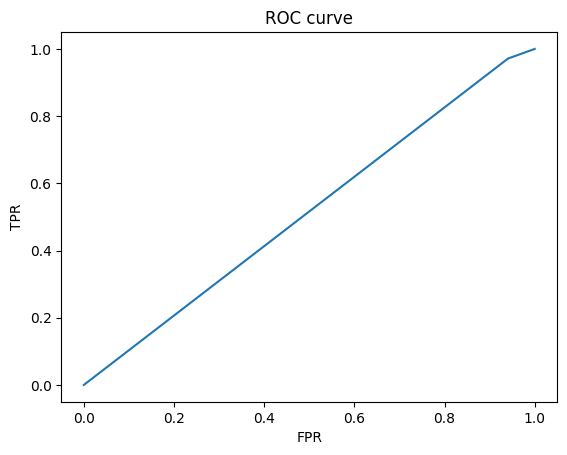

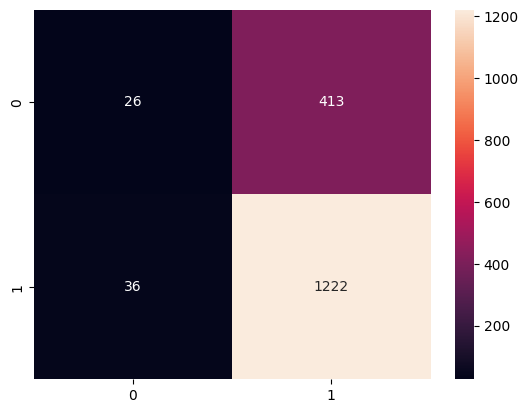

In [63]:
logreg_results = MLT.tune_logistic_regression(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [64]:
best_logreg_model_split = logreg_results[0]

### ___6.4. M√¥ h√¨nh h·ªçc m√°y - Random forest - split___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 42, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 197}
Best score (RandomForestClassifier): 0.7555996670295191
Best Random Forest Accuracy: 0.7690041249263406
Best Random Forest Precision: 0.9705882352941176
Best Random Forest Recall: 0.774746192893401
Best Random Forest AUC: 0.5809660994238242
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.69      0.19      0.30       439
           1       0.77      0.97      0.86      1258

    accuracy                           0.77      1697
   macro avg       0.73      0.58      0.58      1697
weighted avg       0.75      0.77      0.72      1697

ROC_AUC_SCORE is  0.5809660994238242


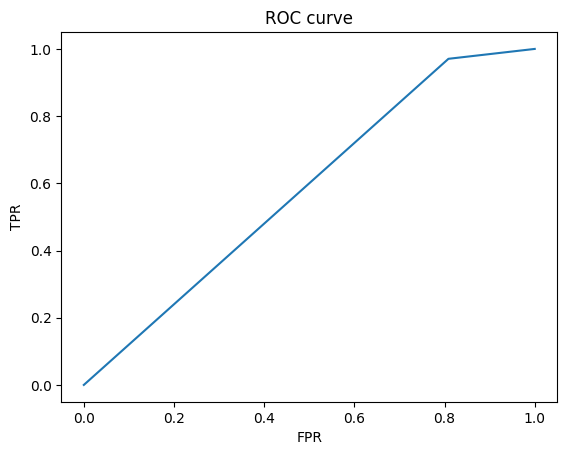

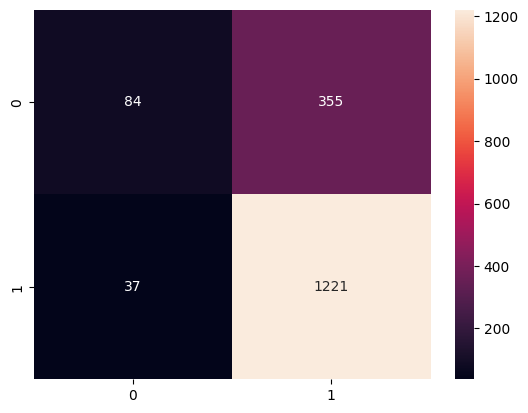

In [65]:
rf_results = MLT.tune_random_forest(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [66]:
best_rf_model_split = rf_results[0]

### ___6.5. M√¥ h√¨nh h·ªçc m√°y - Navie Bayes - split___

Best hyperparameters (MultinomialNB): {'alpha': 6.114762302756431}
Best score (MultinomialNB): 0.7225990147633554
Best Navie Bayes Accuracy: 0.7189157336476134
Best Naive Bayes Precision: 0.8839427662957074
Best Navie Bayes Recall: 0.7706167706167706
Best Naive Bayes AUC: 0.5649782168608377
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.43      0.25      0.31       439
           1       0.77      0.88      0.82      1258

    accuracy                           0.72      1697
   macro avg       0.60      0.56      0.57      1697
weighted avg       0.68      0.72      0.69      1697

ROC_AUC_SCORE is  0.5649782168608377


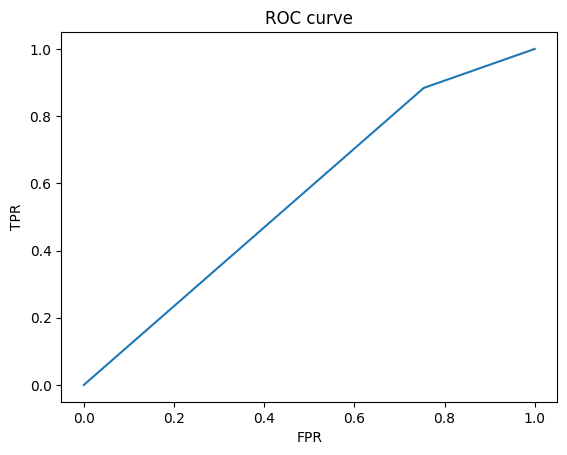

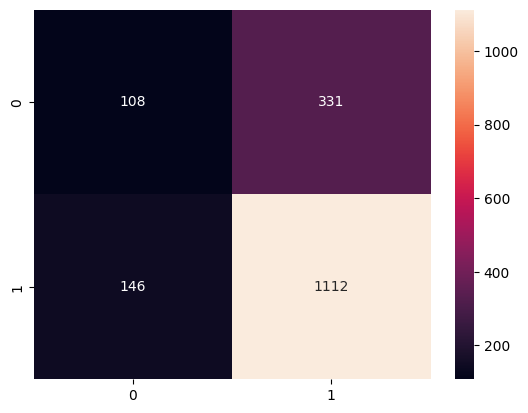

In [67]:
nb_results = MLT.tune_multinomial_nb(train_x_padded1, train_y1, val_x_padded1, val_y1)

In [68]:
best_nb_results_split = nb_results[0]

### ___6.6. M√¥ h√¨nh h·ªçc s√¢u - LSTM - split___

In [84]:
train_x_prepared1 = np.array(train_x_padded1)
val_x_prepared1 = np.array(val_x_padded1)

train_y_prepared1 = np.array(train_y1)
val_y_prepared1 = np.array(val_y1)

In [85]:
def build_model(hp):
    model = Sequential()
    embedding_dim = 16
    model.add(Embedding(input_dim=num_words1, output_dim=embedding_dim, input_length=max_len1))

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )
    return model

In [86]:
base_dir = r'sentiment_NKK'
project_name = 'intro_to_ktt'
directory = os.path.join(base_dir, project_name)

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory=base_dir,
    project_name=project_name
)

# Ti·∫øn h√†nh t√¨m ki·∫øm si√™u tham s·ªë
tuner.search(train_x_prepared1, train_y_prepared1, epochs=20, validation_data=(val_x_prepared1, val_y_prepared1))

Trial 5 Complete [00h 10m 30s]
val_accuracy: 0.9033588767051697

Best val_accuracy So Far: 0.9033588767051697
Total elapsed time: 00h 24m 56s


In [87]:
# L·∫•y c√°c si√™u tham s·ªë t·ªët nh·∫•t
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
LSTM units: 64
Number of LSTM layers: 3
Learning rate: 0.005300696019167498
